# Chapter 5, Example 3b
## Three-way data split on Iris data - multiple experiments

In [1]:
import torch
from torch import nn

from sklearn import datasets

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lr = 0.1
no_epochs = 1000

no_labels = 3
no_features = 4
hidden_units = [2, 4, 6, 8, 10, 12]

no_folds = 3
no_exps = 10

seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
no_inputs = 4
no_outputs = 3

# input data
iris = datasets.load_iris()
iris.data -= np.mean(iris.data, axis=0)

no_data = len(iris.data)

X = iris.data

# convert the targets into one-hot matrix
Y = np.zeros((no_data, no_outputs))
for i in range(no_data):
    Y[i, iris.target[i]] = 1
    
print(np.shape(X))
print(np.shape(Y))

(150, 4)
(150, 3)


In [4]:
class FFN(nn.Module):
    def __init__(self, no_features, hidden_units, no_labels):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, no_labels),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

In [5]:
def train_exp(X, Y):

    x_train, y_train = X[:50], Y[:50]
    x_valid, y_valid = X[50:100], Y[50:100] 
    x_test, y_test = X[100:], Y[100:]

    acc = []
    for no_hidden in hidden_units:
        
        model = FFN(no_inputs, no_hidden, no_outputs)
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
        for epoch in range(no_epochs):
            pred = model(torch.tensor(x_train, dtype=torch.float))
            loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        pred = model(torch.tensor(x_valid, dtype=torch.float))
        acc_ = (pred.argmax(1) == torch.tensor(y_valid, dtype=torch.float).argmax(1)).type(torch.float).mean()
    
        acc.append(acc_.item())
        
    no_hidden = hidden_units[np.argmax(acc)]
    
    x_train, y_train = X[:100], Y[:100]
    
    model = FFN(no_inputs, no_hidden, no_outputs)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for epoch in range(no_epochs):
        pred = model(torch.tensor(x_train, dtype=torch.float))
        loss = loss_fn(pred, torch.tensor(y_train, dtype=torch.float))
    
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pred = model(torch.tensor(x_test, dtype=torch.float))
    acc_ = (pred.argmax(1) == torch.tensor(y_test, dtype=torch.float).argmax(1)).type(torch.float).mean()

    
    return no_hidden, acc_

In [6]:
no_hidden, acc = [], []
for exp in range(no_exps):
        
    idx = np.arange(no_data)
    np.random.shuffle(idx)

    no_hidden_, acc_ = train_exp(X[idx], Y[idx])
        
    no_hidden.append(no_hidden_)
    acc.append(acc_)
    print('exp %d: hidden units %d, accuracy %g'%(exp, no_hidden[exp], acc[exp]))

exp 0: hidden units 8, accuracy 1
exp 1: hidden units 4, accuracy 0.94
exp 2: hidden units 4, accuracy 0.94
exp 3: hidden units 4, accuracy 0.96
exp 4: hidden units 4, accuracy 0.8
exp 5: hidden units 4, accuracy 0.98
exp 6: hidden units 4, accuracy 0.98
exp 7: hidden units 2, accuracy 0.98
exp 8: hidden units 6, accuracy 0.96
exp 9: hidden units 4, accuracy 0.94


In [7]:
hidden_counts = np.zeros(len(hidden_units))
acc_ = np.zeros(len(hidden_units))
for exp in range(no_exps):
    hidden_counts[no_hidden[exp]//2-1] += 1
    acc_[no_hidden[exp]//2-1] += acc[exp]
    
opt_hidden = hidden_units[np.argmax(hidden_counts)]
opt_acc = acc_[opt_hidden//2-1]/hidden_counts[opt_hidden//2-1]
print('* %d hidden unit *'%opt_hidden)
print('* accuracy %g *'%opt_acc)

* 4 hidden unit *
* accuracy 0.934286 *


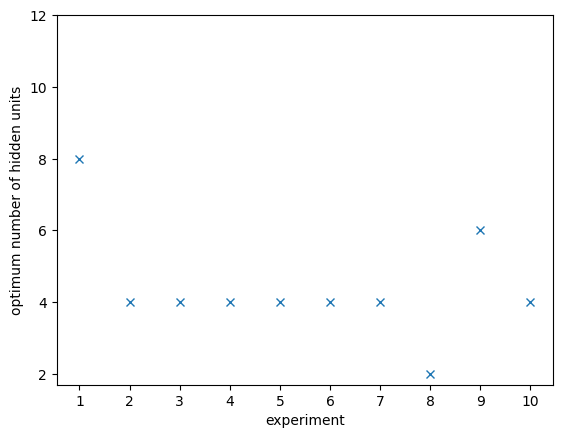

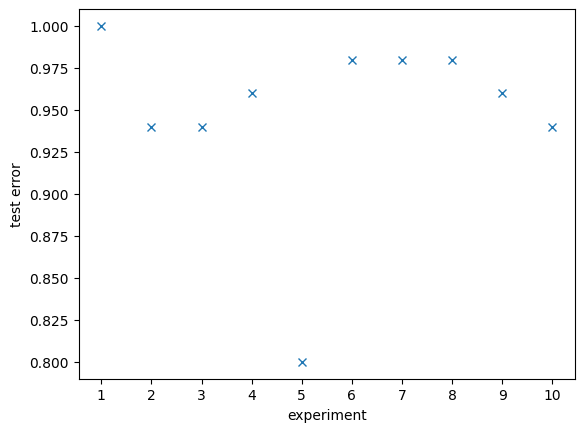

In [16]:
plt.figure(1)
plt.plot(range(no_exps), no_hidden, marker = 'x', linestyle = 'None')
plt.yticks(hidden_units)
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('optimum number of hidden units')

plt.figure(2)
plt.plot(range(no_exps), acc, marker = 'x', linestyle = 'None')
plt.xticks(range(no_exps), np.arange(no_exps)+1)
plt.xlabel('experiment')
plt.ylabel('test error')
    
plt.show()